# Import Libraries and Constants

In [1]:
import numpy as np
import pytalises as pt
import matplotlib.pyplot as plt
from scipy.optimize import root
import itertools as it
from matplotlib import animation, rc
from IPython.display import HTML
from itertools import chain
import warnings

warnings.filterwarnings('ignore')

# Parameters for Rb atoms
N = 3e4
m = 1.4447e-25
hbar = 1.0545718e-34
c = 299792458
a_s = 100*0.00529
g = N*((4*np.pi*hbar**2*a_s)/m)
g = g*1.82e-3

# Parameters for Bragg diffraction
v = 0
omega_ig = 2*np.pi*384.230484468e12
Delta = 2*np.pi*1e9
f_Rabi = 2.0e3
omega_Rabi = 2*np.pi*f_Rabi
Omega = np.sqrt(2*omega_Rabi*Delta) # single photon rabi frequency -> omega_rabi = Omega1*Omega2/(2*Delta) with Omega1=Omega2= Omega
omega_1 = omega_ig-Delta
k_1 = omega_1/c
k_2 = root(lambda k_2: hbar/2/m*(k_1-k_2)**2 + (k_1-k_2)*v - (omega_1 - c*np.abs(k_2)) , -k_1).x
omega_2 = c*np.abs(k_2)
delta = omega_1-omega_2

# Define grid size
N_x = 8*1024
N_y = 128

x_min = 600.0e-6
x_max = 600.0e-6

y_min = 12.5e-6
y_max = 12.5e-6


# Conversion of units
xC = 1e-6 # from m to µm
tC = 1e-6 # from s to µs

# Imaginary time evolution in magnetic trap

In [2]:
psi_i = pt.Wavefunction("exp(-((x-x0)**2)/(2*sig_x**2))*exp(-((y-y0)**2)/(2*sig_y**2))", 
                      variables = {'x0': 0, 'sig_x':  10.0e-6, 'y0': 0, 'sig_y':  10.0e-6 }, 
                      number_of_grid_points = (N_x,N_y,), spatial_ext = [(-x_min,x_max),(-y_min,y_max)],
                      m = m,normalize_const = 1)

for i in range(200):
    
    psi_i.propagate("(0.5*m*(omega_x**2*x**2 + omega_y**2*(y-y0)**2)/hbar) + ((g*abs(psi0)**2)/hbar)", 
                  variables = {'omega_x': 2*np.pi*131,'omega_y': 2*np.pi*127,'y0': 0, 'm': m, 'hbar': hbar, 'g': g}, 
                  diag = True, num_time_steps = 1, delta_t = -1j*1e-4)
     
    # normalize wave function to atom number
    psi_i.normalize_to(1)

In [3]:
# save the wavefunction amplitudes to substitue in newly defined wavefunction with internel states
loadedArr = psi_i.amp

psi = pt.Wavefunction(["exp(-((x-x0)/(2*sig_x))**2)*exp(-((y-y0)/(2*sig_y))**2)","0", "0"], 
                      variables = {'x0': 0, 'sig_x':  20.0e-6, 'y0': 0, 'sig_y':  10.0e-6 }, 
                      number_of_grid_points = (N_x, N_y), spatial_ext = [(-x_min,x_max),(-y_min,y_max)],
                      m = m, normalize_const = 1)

# substitute amplitude from ITE data

for i in range(len(psi.amp[:,:,0])):
    psi.amp[:,:,0][i] = loadedArr[i]
    

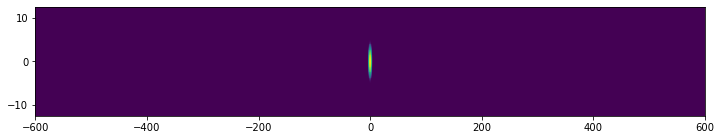

In [4]:
fig, ax1 = plt.subplots(1, 1, sharey=False, figsize=(12, 2),)
ax1.pcolormesh(psi.r[0]/xC, psi.r[1]/xC, np.abs(psi.amp[:,:,0].T)**2, rasterized=True)
ax1.set_aspect('auto')

# ax1.set_xlabel('$X$,(µm)', fontsize = 10)
# ax1.set_ylabel('$Y$,(µm)', fontsize = 10)

# ax1.set_xlim([-10,10])
# ax1.set_ylim([-10,10])

# plot in momentum space
# psi.fft()
# kx = np.roll(psi.k[0]/k_1,int(0.5*N_x))
# ky = np.roll(psi.k[1]/k_1,int(0.5*N_y))
# nk = np.abs(np.roll(np.roll(psi.amp[:,:,0].T,int(0.5*N_y),axis=0),int(0.5*N_x),axis=1))**2
# ax2.pcolormesh(kx,ky,nk, rasterized=True,shading='auto')
# psi.ifft()
# ax2.set_xlabel('$X$,($\mathrm{µm^{-1}}$)')
# ax2.set_ylabel('$Y$,($\mathrm{µm^{-1}}$)')

# plt.savefig("2D_mesh1.svg", dpi = 300)
# plt.savefig("2D_mesh1.png", dpi = 300)
# plt.savefig("2D_mesh1.pdf", dpi = 300) 

# Propagation in waveguide

In [5]:
# Waveguide potential
V = ["(0.5*m*(omega_x**2*x**2 + omega_y**2*y**2)/hbar) + ((g*abs(psi0)**2)/hbar)", "0","0","0","0","0"]

for i in range(300):

        psi.propagate(V, variables = {'omega_x': 2*np.pi*0,'omega_y': 2*np.pi*100, 'm': m, 'hbar': hbar, 'g': g}, 
                      num_time_steps = 1, delta_t = 1e-4)

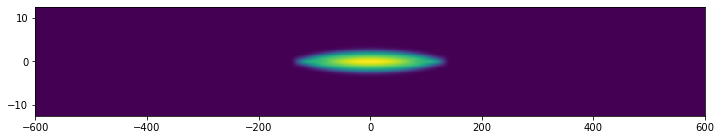

In [6]:
fig, ax1 = plt.subplots(1, 1, sharey=False, figsize=(12, 2),)
ax1.pcolormesh(psi.r[0]/xC, psi.r[1]/xC, np.abs(psi.amp[:,:,0].T)**2, rasterized=True)
ax1.set_aspect('auto')

# ax1.set_xlabel('$X$,(µm)', fontsize = 10)
# ax1.set_ylabel('$Y$,(µm)', fontsize = 10)
# ax1.set_xlim([-10,10])
# ax1.set_ylim([-10,10])

# psi.fft()
# kx = np.roll(psi.k[0]/k_1,int(0.5*N_x))
# ky = np.roll(psi.k[1]/k_1,int(0.5*N_y))
# nk = np.abs(np.roll(np.roll(psi.amp[:,:,0].T,int(0.5*N_y),axis=0),int(0.5*N_x),axis=1))**2
# ax2.pcolormesh(kx,ky,nk, rasterized=True,shading='auto')
# psi.ifft()
# ax2.set_xlabel('$X$,($\mathrm{µm^{-1}}$)')
# ax2.set_ylabel('$Y$,($\mathrm{µm^{-1}}$)')

plt.savefig("2D_mesh2.svg", dpi = 300)
plt.savefig("2D_mesh2.png", dpi = 300)
plt.savefig("2D_mesh2.pdf", dpi = 300) 


# Apply delta-kick collimation

In [7]:
# DKC potential
V = ["(0.5*m*(omega_dx**2*x**2 + omega_dy**2*y**2)/hbar) + (0.5*m*(omega_x**2*x**2 + omega_y**2*y**2)/hbar) + ((g*abs(psi0)**2)/hbar)", "0","0","0","0","0"]

for i in range(53):

    psi.propagate(V, variables = {'omega_dx': 2*np.pi*131,'omega_dy': 2*np.pi*127, 'omega_x': 2*np.pi*0, 'omega_y': 2*np.pi*100, 'm': m, 'hbar': hbar, 'g': g}, 
                  num_time_steps = 1, delta_t = 1e-6)

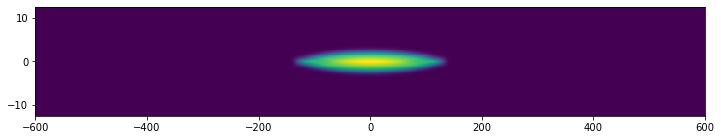

In [8]:
fig, ax1 = plt.subplots(1, 1, sharey=False, figsize=(12, 2),)
ax1.pcolormesh(psi.r[0]/xC, psi.r[1]/xC, np.abs(psi.amp[:,:,0].T)**2, rasterized=True)
ax1.set_aspect('auto')

# ax1.set_xlabel('$X$,(µm)', fontsize = 10)
# ax1.set_ylabel('$Y$,(µm)', fontsize = 10)

# ax1.set_xlim([-10,10])
# ax1.set_ylim([-10,10])

# psi.fft()
# kx = np.roll(psi.k[0]/k_1,int(0.5*N_x))
# ky = np.roll(psi.k[1]/k_1,int(0.5*N_y))
# nk = np.abs(np.roll(np.roll(psi.amp[:,:,0].T,int(0.5*N_y),axis=0),int(0.5*N_x),axis=1))**2
# ax2.pcolormesh(kx,ky,nk, rasterized=True,shading='auto')
# psi.ifft()
# ax2.set_xlabel('$X$,($\mathrm{µm^{-1}}$)')
# ax2.set_ylabel('$Y$,($\mathrm{µm^{-1}}$)')

plt.savefig("2D_mesh3.svg", dpi = 300)
plt.savefig("2D_mesh3.png", dpi = 300)
plt.savefig("2D_mesh3.pdf", dpi = 300) 

# Again propagation in waveguide

In [9]:
V = ["(0.5*m*(omega_x**2*x**2 + omega_y**2*y**2)/hbar) + ((g*abs(psi0)**2)/hbar)", "0","0","0","0","0"]

for i in range(100):

        psi.propagate(V, variables = {'omega_x': 2*np.pi*0,'omega_y': 2*np.pi*100, 'm': m, 'hbar': hbar, 'g': g}, 
                      num_time_steps = 1, delta_t = 1e-4) 


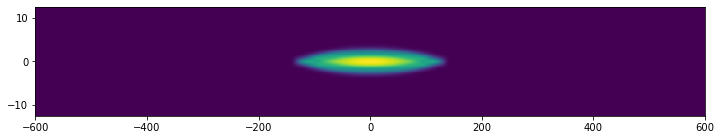

In [10]:
fig, ax1 = plt.subplots(1, 1, sharey=False, figsize=(12, 2),)
ax1.pcolormesh(psi.r[0]/xC, psi.r[1]/xC, np.abs(psi.amp[:,:,0].T)**2, rasterized=True)
ax1.set_aspect('auto')

# ax1.set_xlabel('$X$,(µm)', fontsize = 10)
# ax1.set_ylabel('$Y$,(µm)', fontsize = 10)



# ax1.set_xlim([-10,10])
# ax1.set_ylim([-10,10])

# psi.fft()
# kx = np.roll(psi.k[0]/k_1,int(0.5*N_x))
# ky = np.roll(psi.k[1]/k_1,int(0.5*N_y))
# nk = np.abs(np.roll(np.roll(psi.amp[:,:,0].T,int(0.5*N_y),axis=0),int(0.5*N_x),axis=1))**2
# ax2.pcolormesh(kx,ky,nk, rasterized=True,shading='auto')
# psi.ifft()
# ax2.set_xlabel('$X$,($\mathrm{µm^{-1}}$)')
# ax2.set_ylabel('$Y$,($\mathrm{µm^{-1}}$)')

plt.savefig("2D_mesh4.svg", dpi = 300)
plt.savefig("2D_mesh4.png", dpi = 300)
plt.savefig("2D_mesh4.pdf", dpi = 300) 

# 1st $\pi/2$ pulse in the waveguide

In [11]:
# Bragg beam parameters
w0_1        = 100.0e-6 # width of first Gaussian beam
zR_1        = w0_1**2 * k_1 / 2 # Rayleigh range
w0_2        = 100.0e-6 # width of second Gaussian beam
zR_2        = w0_2**2 * k_2 / 2

bs = np.pi/2 # pi/2 pulse (sqrt(2) accounts for DBD instead of SBD)
pulse_length = bs*(np.sqrt(2)/(omega_Rabi))

Amp_gauss_1 = "1/sqrt(1+(x/zR_1)**2) * exp(-(y/(w0_1*sqrt(1+(x/zR_1)**2)))**2 + 1j*(k_1*y**2/(2*x*(1+(zR_1/x)**2)) + k_1*x - arctan(x/zR_1)) )"
Amp_gauss_2 = "1/sqrt(1+(x/zR_2)**2) * exp(-(y/(w0_2*sqrt(1+(x/zR_2)**2)))**2 + 1j*(k_2*y**2/(2*x*(1+(zR_2/x)**2)) + k_2*x - arctan(x/zR_2)) )"

# DBD potential
V = ["-Delta+(0.5*m*(omega_x**2*x**2 + omega_y**2*y**2)/hbar) + ((g*abs(psi0)**2)/hbar)", "Omega/2 * ("+Amp_gauss_1+"+"+Amp_gauss_2+"*exp(1j*delta*t))","Omega/2 * ("+Amp_gauss_1+"*exp(1j*delta*t)+"+Amp_gauss_2+")", "0","0","0"]

num_time_steps = 100

for i in range(num_time_steps):
    
    psi.propagate(V, num_time_steps = 1,
                      delta_t = pulse_length/num_time_steps,
                      variables={'Omega': Omega, 'c': c, 'v': v,'omega_1': omega_1, 'k_1': k_1, 'w0_1': w0_1, 'zR_1': zR_1,'omega_2': omega_2, 'k_2': k_2, 'w0_2': w0_2, 'zR_2': zR_2,'Delta': Delta, 'delta': delta, 'omega_x': 2*np.pi*0,'omega_y': 2*np.pi*100, 'm': m, 'hbar': hbar, 'g': g})
    

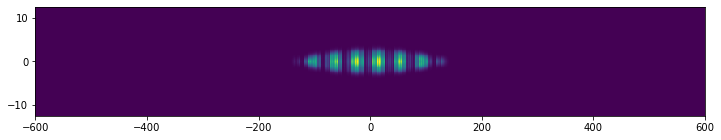

In [12]:
fig, ax1 = plt.subplots(1, 1, sharey=False, figsize=(12, 2),)
ax1.pcolormesh(psi.r[0]/xC, psi.r[1]/xC, np.abs(psi.amp[:,:,0].T)**2, rasterized=True)
ax1.set_aspect('auto')

# ax1.set_xlabel('$X$,(µm)', fontsize = 10)
# ax1.set_ylabel('$Y$,(µm)', fontsize = 10)


# ax1.set_xlim([-10,10])
# ax1.set_ylim([-10,10])

# psi.fft()
# kx = np.roll(psi.k[0]/k_1,int(0.5*N_x))
# ky = np.roll(psi.k[1]/k_1,int(0.5*N_y))
# nk = np.abs(np.roll(np.roll(psi.amp[:,:,0].T,int(0.5*N_y),axis=0),int(0.5*N_x),axis=1))**2
# ax2.pcolormesh(kx,ky,nk, rasterized=True,shading='auto')
# psi.ifft()
# ax2.set_xlabel('$X$,($\mathrm{µm^{-1}}$)')
# ax2.set_ylabel('$Y$,($\mathrm{µm^{-1}}$)')

plt.savefig("2D_mesh5.svg", dpi = 300)
plt.savefig("2D_mesh5.png", dpi = 300)
plt.savefig("2D_mesh5.pdf", dpi = 300) 

In [13]:
# propagate for 30 ms in waveguide
V = ["(0.5*m*(omega_x**2*x**2 + omega_y**2*y**2)/hbar) + ((g*abs(psi0)**2)/hbar)", "0","0","0","0","0"]

for i in range(300):
    
    psi.propagate(V, variables = {'omega_x': 2*np.pi*0,'omega_y': 2*np.pi*100, 'm': m, 'hbar': hbar, 'g': g}, 
          num_time_steps = 1, delta_t = 1e-4)
    

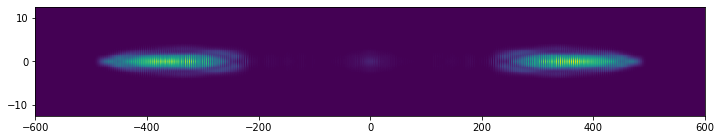

In [14]:
fig, ax1 = plt.subplots(1, 1, sharey=False, figsize=(12, 2),)
ax1.pcolormesh(psi.r[0]/xC, psi.r[1]/xC, np.abs(psi.amp[:,:,0].T)**2, rasterized=True)
ax1.set_aspect('auto')

# ax1.set_xlabel('$X$,(µm)', fontsize = 10)
# ax1.set_ylabel('$Y$,(µm)', fontsize = 10)

# ax1.set_xlim([-10,10])
# ax1.set_ylim([-10,10])

# psi.fft()
# kx = np.roll(psi.k[0]/k_1,int(0.5*N_x))
# ky = np.roll(psi.k[1]/k_1,int(0.5*N_y))
# nk = np.abs(np.roll(np.roll(psi.amp[:,:,0].T,int(0.5*N_y),axis=0),int(0.5*N_x),axis=1))**2
# ax2.pcolormesh(kx,ky,nk, rasterized=True,shading='auto')
# psi.ifft()
# ax2.set_xlabel('$X$,($\mathrm{µm^{-1}}$)')
# ax2.set_ylabel('$Y$,($\mathrm{µm^{-1}}$)')

plt.savefig("2D_mesh6.svg", dpi = 300)
plt.savefig("2D_mesh6.png", dpi = 300)
plt.savefig("2D_mesh6.pdf", dpi = 300) 


# $\pi$ pulse in the waveguide

In [15]:
V = ["-Delta+(0.5*m*(omega_x**2*x**2 + omega_y**2*y**2)/hbar) + ((g*abs(psi0)**2)/hbar)", "Omega/2 * ("+Amp_gauss_1+"+"+Amp_gauss_2+"*exp(1j*delta*t))","Omega/2 * ("+Amp_gauss_1+"*exp(1j*delta*t)+"+Amp_gauss_2+")", "0","0","0"]

for i in range(num_time_steps):
    
    psi.propagate(V, num_time_steps = 1,
                      delta_t = 2*pulse_length/num_time_steps,
                      variables={'Omega': Omega, 'c': c, 'v': v,'omega_1': omega_1, 'k_1': k_1, 'w0_1': w0_1, 'zR_1': zR_1,'omega_2': omega_2, 'k_2': k_2, 'w0_2': w0_2, 'zR_2': zR_2,'Delta': Delta, 'delta': delta, 'omega_x': 2*np.pi*0,'omega_y': 2*np.pi*100, 'm': m, 'hbar': hbar, 'g': g})


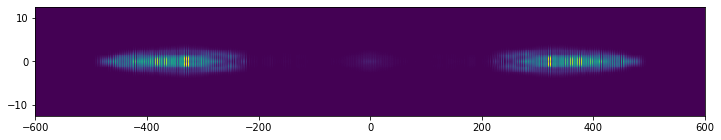

In [16]:
fig, ax1 = plt.subplots(1, 1, sharey=False, figsize=(12, 2),)
ax1.pcolormesh(psi.r[0]/xC, psi.r[1]/xC, np.abs(psi.amp[:,:,0].T)**2, rasterized=True)
ax1.set_aspect('auto')

# ax1.set_xlabel('$X$,(µm)', fontsize = 10)
# ax1.set_ylabel('$Y$,(µm)', fontsize = 10)

# ax1.set_xlim([-10,10])
# ax1.set_ylim([-10,10])

# psi.fft()
# kx = np.roll(psi.k[0]/k_1,int(0.5*N_x))
# ky = np.roll(psi.k[1]/k_1,int(0.5*N_y))
# nk = np.abs(np.roll(np.roll(psi.amp[:,:,0].T,int(0.5*N_y),axis=0),int(0.5*N_x),axis=1))**2
# ax2.pcolormesh(kx,ky,nk, rasterized=True,shading='auto')
# psi.ifft()
# ax2.set_xlabel('$X$,($\mathrm{µm^{-1}}$)')
# ax2.set_ylabel('$Y$,($\mathrm{µm^{-1}}$)')

plt.savefig("2D_mesh7.svg", dpi = 300)
plt.savefig("2D_mesh7.png", dpi = 300)
plt.savefig("2D_mesh7.pdf", dpi = 300) 

In [17]:
# again propagate for 30 ms in waveguide

V = ["(0.5*m*(omega_x**2*x**2 + omega_y**2*y**2)/hbar) + ((g*abs(psi0)**2)/hbar)", "0","0","0","0","0"]

for i in range(300):
    
    psi.propagate(V, variables = {'omega_x': 2*np.pi*0,'omega_y': 2*np.pi*100, 'm': m, 'hbar': hbar, 'g': g}, 
          num_time_steps = 1, delta_t = 1e-4)
    
    

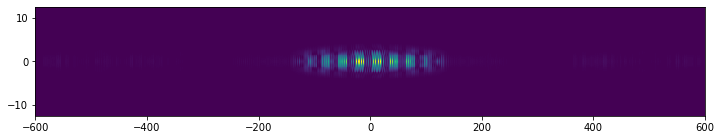

In [18]:
fig, ax1 = plt.subplots(1, 1, sharey=False, figsize=(12, 2),)
ax1.pcolormesh(psi.r[0]/xC, psi.r[1]/xC, np.abs(psi.amp[:,:,0].T)**2, rasterized=True)
ax1.set_aspect('auto')

# ax1.set_xlabel('$X$,(µm)', fontsize = 10)
# ax1.set_ylabel('$Y$,(µm)', fontsize = 10)


# ax1.set_xlim([-10,10])
# ax1.set_ylim([-10,10])

# psi.fft()
# kx = np.roll(psi.k[0]/k_1,int(0.5*N_x))
# ky = np.roll(psi.k[1]/k_1,int(0.5*N_y))
# nk = np.abs(np.roll(np.roll(psi.amp[:,:,0].T,int(0.5*N_y),axis=0),int(0.5*N_x),axis=1))**2
# ax2.pcolormesh(kx,ky,nk, rasterized=True,shading='auto')
# psi.ifft()
# ax2.set_xlabel('$X$,($\mathrm{µm^{-1}}$)')
# ax2.set_ylabel('$Y$,($\mathrm{µm^{-1}}$)')

plt.savefig("2D_mesh8.svg", dpi = 300)
plt.savefig("2D_mesh8.png", dpi = 300)
plt.savefig("2D_mesh8.pdf", dpi = 300) 


# 2nd $\pi/2$ pulse

In [19]:
V = ["-Delta+(0.5*m*(omega_x**2*x**2 + omega_y**2*y**2)/hbar) + ((g*abs(psi0)**2)/hbar)", "Omega/2 * ("+Amp_gauss_1+"+"+Amp_gauss_2+"*exp(1j*delta*t))","Omega/2 * ("+Amp_gauss_1+"*exp(1j*delta*t)+"+Amp_gauss_2+")", "0","0","0"]

for i in range(num_time_steps):
    
    psi.propagate(V, num_time_steps = 1,
                      delta_t = pulse_length/num_time_steps,
                      variables={'Omega': Omega, 'c': c, 'v': v,'omega_1': omega_1, 'k_1': k_1, 'w0_1': w0_1, 'zR_1': zR_1,'omega_2': omega_2, 'k_2': k_2, 'w0_2': w0_2, 'zR_2': zR_2,'Delta': Delta, 'delta': delta, 'omega_x': 2*np.pi*0,'omega_y': 2*np.pi*100, 'm': m, 'hbar': hbar, 'g': g})
    

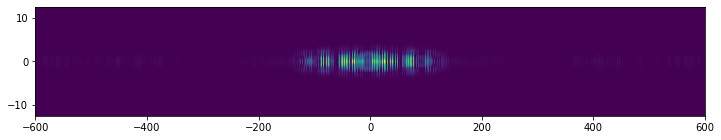

In [20]:
fig, ax1 = plt.subplots(1, 1, sharey=False, figsize=(12, 2),)
ax1.pcolormesh(psi.r[0]/xC, psi.r[1]/xC, np.abs(psi.amp[:,:,0].T)**2, rasterized=True)
ax1.set_aspect('auto')

# ax1.set_xlabel('$X$,(µm)', fontsize = 10)
# ax1.set_ylabel('$Y$,(µm)', fontsize = 10)


# ax1.set_xlim([-10,10])
# ax1.set_ylim([-10,10])

# psi.fft()
# kx = np.roll(psi.k[0]/k_1,int(0.5*N_x))
# ky = np.roll(psi.k[1]/k_1,int(0.5*N_y))
# nk = np.abs(np.roll(np.roll(psi.amp[:,:,0].T,int(0.5*N_y),axis=0),int(0.5*N_x),axis=1))**2
# ax2.pcolormesh(kx,ky,nk, rasterized=True,shading='auto')
# psi.ifft()
# ax2.set_xlabel('$X$,($\mathrm{µm^{-1}}$)')
# ax2.set_ylabel('$Y$,($\mathrm{µm^{-1}}$)')

plt.savefig("2D_mesh9.svg", dpi = 300)
plt.savefig("2D_mesh9.png", dpi = 300)
plt.savefig("2D_mesh9.pdf", dpi = 300) 


In [21]:
# propagate for 35 ms in waveguide before detection

V = ["(0.5*m*(omega_x**2*x**2 + omega_y**2*y**2)/hbar) + ((g*abs(psi0)**2)/hbar)", "0","0","0","0","0"]

for i in range(400):
    
    psi.propagate(V, variables = {'omega_x': 2*np.pi*0,'omega_y': 2*np.pi*100, 'm': m, 'hbar': hbar, 'g': g}, 
          num_time_steps = 1, delta_t = 1e-4)
    

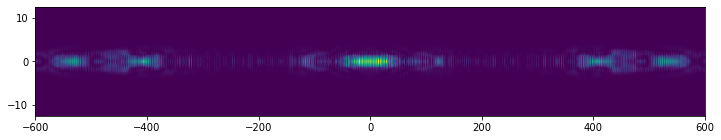

In [22]:
fig, ax1 = plt.subplots(1, 1, sharey=False, figsize=(12, 2),)
ax1.pcolormesh(psi.r[0]/xC, psi.r[1]/xC, np.abs(psi.amp[:,:,0].T)**2, rasterized=True)
ax1.set_aspect('auto')

# ax1.set_xlabel('$X$,(µm)', fontsize = 10)
# ax1.set_ylabel('$Y$,(µm)', fontsize = 10)

# ax1.set_xlim([-10,10])
# ax1.set_ylim([-10,10])

# psi.fft()
# kx = np.roll(psi.k[0]/k_1,int(0.5*N_x))
# ky = np.roll(psi.k[1]/k_1,int(0.5*N_y))
# nk = np.abs(np.roll(np.roll(psi.amp[:,:,0].T,int(0.5*N_y),axis=0),int(0.5*N_x),axis=1))**2
# ax2.pcolormesh(kx,ky,nk, rasterized=True,shading='auto')
# psi.ifft()
# ax2.set_xlabel('$X$,($\mathrm{µm^{-1}}$)')
# ax2.set_ylabel('$Y$,($\mathrm{µm^{-1}}$)')

plt.savefig("2D_mesh10.svg", dpi = 300)
plt.savefig("2D_mesh10.png", dpi = 300)
plt.savefig("2D_mesh10.pdf", dpi = 300) 